## Mimic3 Demo

[Mimic3](https://www.kaggle.com/datasets/asjad99/mimiciii) is a large open-access anonymized single-center database which consists of comprehensive clinical data of 61,532 critical care admissions from 2001–2012 collected at a Boston teaching hospital. Dataset consists of 47 features (including demographics, vitals, and lab test results) on a cohort of sepsis patients who meet the sepsis-3 definition criteria.

Due to the privacy concerns, we utilized a subset of he original Mimic3 data that is publicly available on Kaggle. For illustration purpose, we selected several representative features for the following analysis:

*   **Glucose**: glucose values of patients
*   **paO2**: The partial pressure of oxygen
*   **PaO2_FiO2**: The partial pressure of oxygen (PaO2)/fraction of oxygen delivered (FIO2) ratio.
*   **SOFA**: Sepsis-related Organ Failure Assessment score to describe organ dysfunction/failure.
*   **iv-input**: the volumn of fluids that have been administered to the patient.
*   **died_within_48h_of_out_time**:  the mortality status of the patient after 48 hours of being administered.

In the next sections, we will start from causal discovery learning to learn significant causal diagram from the data, and then quantify the effect of treatment ('iv_input') on the outcome (mortality status, denoted by 'died_within_48h_of_out_time' variable in the data) through causal effect learning.

## Causal Discovery Learning

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import os
import pickle
import random
import math
import time 

from datetime import datetime
import matplotlib.pyplot as plt

from multiprocessing import Pool
 
from tqdm import tqdm
from functools import partial 

os.environ["OMP_NUM_THREADS"] = "1"

In [2]:

mimic3_data = pd.read_csv("C:/Users/Public/Causal-Decision-Making/5_Case_Study/MIMIC3/subset_mimic3_sepsis_data.csv")
mimic3_data.head(6)

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/Public/Causal-Decision-Making/5_Case_Study/MIMIC3/subset_mimic3_sepsis_data.csv'

In [ ]:
##### Import Packages 
from causaldm.learners.Causal_Discovery_Learning.utils import *
from causaldm.learners.Case_Study.MIMIC3 import *
from numpy.random import randn
from random import seed as rseed
from numpy.random import seed as npseed

In [ ]:
mimic3_data.columns

Index(['bloc', 'icustayid', 'charttime', 'gender', 'age', 'elixhauser',
       're_admission', 'died_in_hosp', 'died_within_48h_of_out_time',
       'mortality_90d', 'delay_end_of_record_and_discharge_or_death',
       'Weight_kg', 'GCS', 'HR', 'SysBP', 'MeanBP', 'DiaBP', 'RR', 'SpO2',
       'Temp_C', 'FiO2_1', 'Potassium', 'Sodium', 'Chloride', 'Glucose', 'BUN',
       'Creatinine', 'Magnesium', 'Calcium', 'Ionised_Ca', 'CO2_mEqL', 'SGOT',
       'SGPT', 'Total_bili', 'Albumin', 'Hb', 'WBC_count', 'Platelets_count',
       'PTT', 'PT', 'INR', 'Arterial_pH', 'paO2', 'paCO2', 'Arterial_BE',
       'Arterial_lactate', 'HCO3', 'mechvent', 'Shock_Index', 'PaO2_FiO2',
       'median_dose_vaso', 'max_dose_vaso', 'input_total', 'input_4hourly',
       'output_total', 'output_4hourly', 'cumulated_balance', 'SOFA', 'SIRS',
       'vaso_input', 'iv_input', 'reward'],
      dtype='object')

In [ ]:
# ----------- Estimated DAG based on NOTEARS
#from obspy.imaging.beachball import plot_mt
mimic3_data_final = mimic3_data
# selected = ['gender',  
#        're_admission', 'died_within_48h_of_out_time', 
#        'Weight_kg', 'GCS',  'SpO2',
#        'Temp_C', 'FiO2_1',  'Chloride', 'Glucose', 'BUN', 'WBC_count', 'paO2', 'paCO2', 
#             'PaO2_FiO2',
#        'median_dose_vaso', 'max_dose_vaso', 'SOFA', 'SIRS',
#        'vaso_input', 'iv_input', 'reward']
# selected = ['gender',   
#        'Weight_kg', 'GCS', # 'SpO2', 'FiO2_1',  'Chloride', 'paO2', 'paCO2',  'PaO2_FiO2',
#        #'median_dose_vaso', 'max_dose_vaso',  
#             'cumulated_balance', 
#        'vaso_input', 'iv_input', 'SOFA']

selected = ['Glucose','paO2','PaO2_FiO2',  'iv_input', 'SOFA','died_within_48h_of_out_time']

sample_demo = mimic3_data_final[:5000][selected]
est_mt = notears_linear(np.array(sample_demo), lambda1=0, loss_type='l2',w_threshold=0.1)

# ----------- Plot Associated Matrix for the Estimated DAG based on NOTEARS

# calculate_effect(est_mt)

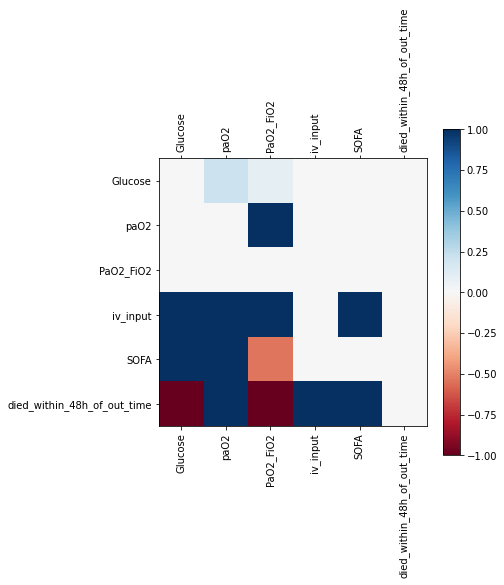

In [ ]:

plot_mt(est_mt, labels_name=selected, file_name='demo_res_mt')


In [ ]:
est_mt[3,4] # SOFA -> iv_input 

1.4497709639893197

In [ ]:
est_mt[5,3] # iv_input -> died_within_48h_of_out_time

1.2259495770059539

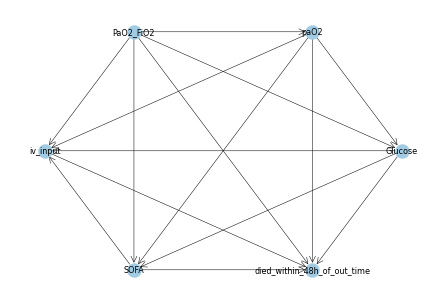

In [ ]:
plot_net(est_mt, labels_name=selected, file_name='demo_res_net')



In [ ]:

sum(mimic3_data['cumulated_balance'])/len(mimic3_data)

2764.968979885058

In [ ]:
sum(mimic3_data['output_total'])/len(mimic3_data)

961.0344827586207

In [ ]:
sum(mimic3_data['input_total'])/len(mimic3_data)

3726.0034626436773

## Causal Effect Learning

In [ ]:
# in_input is the treatment, SOFA is the mediator, and the died_within_48hour is the outcome. 
# All the rest nodes can be viewed as the confounders.

In [ ]:
mimic3_data.columns

Index(['bloc', 'icustayid', 'charttime', 'gender', 'age', 'elixhauser',
       're_admission', 'died_in_hosp', 'died_within_48h_of_out_time',
       'mortality_90d', 'delay_end_of_record_and_discharge_or_death',
       'Weight_kg', 'GCS', 'HR', 'SysBP', 'MeanBP', 'DiaBP', 'RR', 'SpO2',
       'Temp_C', 'FiO2_1', 'Potassium', 'Sodium', 'Chloride', 'Glucose', 'BUN',
       'Creatinine', 'Magnesium', 'Calcium', 'Ionised_Ca', 'CO2_mEqL', 'SGOT',
       'SGPT', 'Total_bili', 'Albumin', 'Hb', 'WBC_count', 'Platelets_count',
       'PTT', 'PT', 'INR', 'Arterial_pH', 'paO2', 'paCO2', 'Arterial_BE',
       'Arterial_lactate', 'HCO3', 'mechvent', 'Shock_Index', 'PaO2_FiO2',
       'median_dose_vaso', 'max_dose_vaso', 'input_total', 'input_4hourly',
       'output_total', 'output_4hourly', 'cumulated_balance', 'SOFA', 'SIRS',
       'vaso_input', 'iv_input', 'reward'],
      dtype='object')

In [ ]:
selected = ['Glucose','paO2','PaO2_FiO2',  'iv_input', 'SOFA','died_within_48h_of_out_time']

sample_demo = mimic3_data[selected]

In [ ]:
userinfo_index = np.array([0,1,2,4])
# outcome: died_within_48h_of_out_time (binary)
# treatment: iv_input (binary)
# others: covariates

In [ ]:
sample_demo.iloc[np.where(sample_demo['iv_input']!=0)[0],3]=1 # change the discrete action to binary
data_CEL_selected = sample_demo.copy()
data_CEL_selected.head(6)

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,Glucose,paO2,PaO2_FiO2,iv_input,SOFA,died_within_48h_of_out_time
0,91.000000,103.000000,206.000000,0.0,8,1
1,193.000000,42.000000,105.000000,1.0,8,0
2,117.000000,83.000000,166.000000,1.0,14,1
3,123.200000,133.000000,266.000000,1.0,8,1
4,214.000000,113.000000,282.500000,0.0,7,0
5,229.333333,39.000000,39.000000,0.0,9,0
6,149.000000,64.000000,304.761905,1.0,3,0
7,162.750000,84.000000,210.000000,0.0,6,0
8,120.000000,85.000000,170.000000,1.0,5,0
9,105.000000,161.000000,766.666667,0.0,8,0


In [ ]:
print(sum(data_CEL_selected.iloc[np.where(data_CEL_selected['iv_input']==0)[0],5]==0))
print(sum(data_CEL_selected.iloc[np.where(data_CEL_selected['iv_input']==0)[0],5]==1))
print(sum(data_CEL_selected.iloc[np.where(data_CEL_selected['iv_input']==1)[0],5]==0))
print(sum(data_CEL_selected.iloc[np.where(data_CEL_selected['iv_input']==1)[0],5]==1))
# 58 patients in total

32
4
16
6


In [ ]:
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

#mu0 = GradientBoostingClassifier(max_depth=2)
#mu1 = GradientBoostingClassifier(max_depth=2)

mu0 = LogisticRegression()
mu1 = LogisticRegression()

mu0.fit(data_CEL_selected.iloc[np.where(data_CEL_selected['iv_input']==0)[0],userinfo_index],data_CEL_selected.iloc[np.where(data_CEL_selected['iv_input']==0)[0],5] )
mu1.fit(data_CEL_selected.iloc[np.where(data_CEL_selected['iv_input']==1)[0],userinfo_index],data_CEL_selected.iloc[np.where(data_CEL_selected['iv_input']==1)[0],5] )


# estimate the HTE by T-learner
HTE_T_learner = (mu1.predict_proba(data_CEL_selected.iloc[:,userinfo_index]) - mu0.predict_proba(data_CEL_selected.iloc[:,userinfo_index]))[:,1]

In [ ]:
HTE_T_learner

array([ 0.35193837,  0.15100322,  0.37937706,  0.21685053, -0.00572692,
        0.35366461, -0.10757065,  0.05879746,  0.30753862, -0.27232834,
       -0.08068463,  0.45049988,  0.0060788 , -0.07484116,  0.13040501,
       -0.19635191,  0.1242306 ,  0.66716023,  0.32382886, -0.04121226,
       -0.26585647,  0.33936103, -0.04903773,  0.02095465, -0.00546565,
       -0.06986865, -0.00787551,  0.34063497,  0.11724709,  0.07787983,
        0.31888453,  0.13037105, -0.04135072,  0.90892501,  0.16500385,
       -0.1283525 , -0.14416355,  0.08225486,  0.42131848,  0.00556242,
       -0.10858594, -0.01104204,  0.75754023,  0.03973348,  0.12670468,
        0.03626968, -0.12951083, -0.05274683,  0.3620197 ,  0.0364981 ,
        0.32033171,  0.35990093,  0.07887963, -0.11768663,  0.14273112,
        0.02035232,  0.7821337 ,  0.04273572])

In [ ]:
mu1.predict(data_CEL_selected.iloc[:,userinfo_index])

array([1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0])

In [ ]:
mu0.predict(data_CEL_selected.iloc[:,userinfo_index])

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
np.where(mu1.predict(data_CEL_selected.iloc[:,userinfo_index])-mu0.predict(data_CEL_selected.iloc[:,userinfo_index])==1)[0]

array([ 0,  2, 17, 33, 38, 42, 56])

In [ ]:
sum(HTE_T_learner)/len(data_CEL_selected)

0.13181626090930249

**Conclusion**: iv-input is expected to improve the death-within-48-hours rate by 13.18%.

### exclude SOFA from the covariates list

In [ ]:
selected = ['Glucose','paO2','PaO2_FiO2',  'iv_input','died_within_48h_of_out_time']

sample_demo = mimic3_data[selected]

In [ ]:
userinfo_index = np.array([0,1,2])
# outcome: died_within_48h_of_out_time (binary)
# treatment: iv_input (binary)
# others: covariates

In [ ]:
sample_demo.iloc[np.where(sample_demo['iv_input']!=0)[0],3]=1 # change the discrete action to binary
data_CEL_selected = sample_demo.copy()
data_CEL_selected.head(6)

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,Glucose,paO2,PaO2_FiO2,iv_input,died_within_48h_of_out_time
0,91.000000,103.000000,206.000000,0.0,1
1,193.000000,42.000000,105.000000,1.0,0
2,117.000000,83.000000,166.000000,1.0,1
3,123.200000,133.000000,266.000000,1.0,1
4,214.000000,113.000000,282.500000,0.0,0
5,229.333333,39.000000,39.000000,0.0,0
6,149.000000,64.000000,304.761905,1.0,0
7,162.750000,84.000000,210.000000,0.0,0
8,120.000000,85.000000,170.000000,1.0,0
9,105.000000,161.000000,766.666667,0.0,0


In [ ]:
print(sum(data_CEL_selected.iloc[np.where(data_CEL_selected['iv_input']==0)[0],4]==0))
print(sum(data_CEL_selected.iloc[np.where(data_CEL_selected['iv_input']==0)[0],4]==1))
print(sum(data_CEL_selected.iloc[np.where(data_CEL_selected['iv_input']==1)[0],4]==0))
print(sum(data_CEL_selected.iloc[np.where(data_CEL_selected['iv_input']==1)[0],4]==1))
# 58 patients in total

32
4
16
6


In [ ]:
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

#mu0 = GradientBoostingClassifier(max_depth=2)
#mu1 = GradientBoostingClassifier(max_depth=2)

mu0 = LogisticRegression()
mu1 = LogisticRegression()

mu0.fit(data_CEL_selected.iloc[np.where(data_CEL_selected['iv_input']==0)[0],userinfo_index],data_CEL_selected.iloc[np.where(data_CEL_selected['iv_input']==0)[0],4] )
mu1.fit(data_CEL_selected.iloc[np.where(data_CEL_selected['iv_input']==1)[0],userinfo_index],data_CEL_selected.iloc[np.where(data_CEL_selected['iv_input']==1)[0],4] )


# estimate the HTE by T-learner
HTE_T_learner = (mu1.predict_proba(data_CEL_selected.iloc[:,userinfo_index]) - mu0.predict_proba(data_CEL_selected.iloc[:,userinfo_index]))[:,1]

In [ ]:
HTE_T_learner

array([ 0.34214908,  0.15483742,  0.33360699,  0.21308046, -0.00311157,
        0.359681  , -0.11028062,  0.06525265,  0.32251312, -0.26930135,
       -0.08273835,  0.47329251,  0.00722481, -0.07548401,  0.13385522,
       -0.1992917 ,  0.12232846,  0.67345188,  0.30241027, -0.03958685,
       -0.26278474,  0.32718327, -0.04868508,  0.0261224 , -0.00102555,
       -0.07001004, -0.01674666,  0.33343453,  0.11249884,  0.05936183,
        0.33902806,  0.13446026, -0.04408134,  0.90951684,  0.18122974,
       -0.12890962, -0.14675372,  0.09387125,  0.40208288,  0.00692851,
       -0.1096049 , -0.02037488,  0.76030491,  0.04719836,  0.15350811,
        0.03047809, -0.13395765, -0.05205824,  0.35508516,  0.03555667,
        0.30540774,  0.36072918,  0.07001589, -0.11951063,  0.13380248,
        0.01573469,  0.80052499,  0.04350663])

In [ ]:
mu1.predict(data_CEL_selected.iloc[:,userinfo_index])

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0])

In [ ]:
mu0.predict(data_CEL_selected.iloc[:,userinfo_index])

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
np.where(mu1.predict(data_CEL_selected.iloc[:,userinfo_index])-mu0.predict(data_CEL_selected.iloc[:,userinfo_index])==1)[0]

array([11, 17, 33, 42, 56])

In [ ]:
sum(HTE_T_learner)/len(data_CEL_selected)

0.1311544427995885

**Conclusion**: iv-input is expected to improve the death-within-48-hours rate by 13.18%.

### Regard SOFA as outcome variable

In [ ]:
selected = ['Glucose','paO2','PaO2_FiO2',  'iv_input', 'SOFA']

sample_demo = mimic3_data[selected]

In [ ]:
userinfo_index = np.array([0,1,2])
# outcome: SOFA score (treated as continuous). The smaller, the better
# treatment: iv_input (binary)
# others: covariates

In [ ]:
sample_demo.iloc[np.where(sample_demo['iv_input']!=0)[0],3]=1 # change the discrete action to binary
data_CEL_selected = sample_demo.copy()
data_CEL_selected.head(6)

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,Glucose,paO2,PaO2_FiO2,iv_input,SOFA
0,91.000000,103.000000,206.000000,0.0,8
1,193.000000,42.000000,105.000000,1.0,8
2,117.000000,83.000000,166.000000,1.0,14
3,123.200000,133.000000,266.000000,1.0,8
4,214.000000,113.000000,282.500000,0.0,7
5,229.333333,39.000000,39.000000,0.0,9
6,149.000000,64.000000,304.761905,1.0,3
7,162.750000,84.000000,210.000000,0.0,6
8,120.000000,85.000000,170.000000,1.0,5
9,105.000000,161.000000,766.666667,0.0,8


In [ ]:
print(sum(data_CEL_selected.iloc[np.where(data_CEL_selected['iv_input']==0)[0],4]))
print(sum(data_CEL_selected.iloc[np.where(data_CEL_selected['iv_input']==1)[0],4]))
# 58 patients in total
# the trend looks great: iv_input helps to decrease the overall SOFA score of patients

271
154


In [ ]:
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression

#mu0 = LGBMRegressor(max_depth=2)
#mu1 = LGBMRegressor(max_depth=2)

mu0 = LinearRegression()
mu1 = LinearRegression()

mu0.fit(data_CEL_selected.iloc[np.where(data_CEL_selected['iv_input']==0)[0],userinfo_index],data_CEL_selected.iloc[np.where(data_CEL_selected['iv_input']==0)[0],4] )
mu1.fit(data_CEL_selected.iloc[np.where(data_CEL_selected['iv_input']==1)[0],userinfo_index],data_CEL_selected.iloc[np.where(data_CEL_selected['iv_input']==1)[0],4] )


# estimate the HTE by T-learner
HTE_T_learner = (mu1.predict(data_CEL_selected.iloc[:,userinfo_index]) - mu0.predict(data_CEL_selected.iloc[:,userinfo_index]))

In [ ]:
mu1.predict(data_CEL_selected.iloc[:,userinfo_index])

array([ 7.21870224,  8.40566972,  7.66622106,  7.1879345 ,  7.1901635 ,
        9.85648741,  4.9401981 ,  7.30275857,  7.67184641, -1.36721931,
        3.59254365, 10.12774396, 11.4649726 ,  4.60819096,  7.0017973 ,
        2.11530562,  6.7907991 ,  9.77513013,  7.27653223,  6.27977167,
        1.33523561,  7.63267806,  4.5328774 ,  6.40388746,  5.41585275,
        5.87905889,  6.65355666,  7.46495149,  6.06793454,  6.14837157,
        7.57664137,  7.12229885,  5.81609308, 10.53073325,  6.7307595 ,
       -0.19831203,  4.84101367, 10.84671498,  8.66528849,  9.26055158,
        4.70986044,  6.20867846,  9.64290819,  6.90753136,  7.05010359,
        6.06274677,  5.00564529,  4.82901546,  9.2423345 ,  6.84998288,
        8.6205014 ,  7.75504146,  6.38889206,  0.89695554,  6.82694905,
        6.84062773, 11.17027401,  6.71774599])

In [ ]:
 mu0.predict(data_CEL_selected.iloc[:,userinfo_index])

array([7.89250861, 8.12039556, 7.99682994, 7.8115788 , 7.67692267,
       8.49726147, 7.14091275, 7.81277854, 7.99234011, 5.26287652,
       6.6201452 , 8.55478225, 8.51406748, 6.94066256, 7.81857514,
       6.32446681, 7.65200423, 8.52600314, 7.65274637, 7.43326703,
       6.1311298 , 7.98514328, 6.84965923, 7.59685668, 7.19285778,
       7.39099085, 7.64473278, 7.94732209, 7.59949607, 7.57939714,
       7.97767451, 7.74199621, 7.4573362 , 8.7692076 , 7.68035161,
       5.4551159 , 7.18658372, 8.57316288, 8.24437089, 8.12308573,
       7.07157904, 7.54553513, 8.51033153, 7.72059844, 7.73863371,
       7.3825371 , 7.24976983, 6.92079241, 8.3779517 , 7.690975  ,
       8.17710764, 8.03307371, 7.65368796, 5.74642474, 7.78890149,
       7.73139714, 8.76941559, 7.67403198])

In [ ]:
HTE_T_learner

array([-0.67380637,  0.28527416, -0.33060888, -0.6236443 , -0.48675916,
        1.35922594, -2.20071466, -0.51001997, -0.3204937 , -6.63009583,
       -3.02760156,  1.57296171,  2.95090512, -2.3324716 , -0.81677784,
       -4.20916119, -0.86120512,  1.249127  , -0.37621414, -1.15349536,
       -4.79589419, -0.35246522, -2.31678183, -1.19296922, -1.77700503,
       -1.51193196, -0.99117612, -0.4823706 , -1.53156153, -1.43102557,
       -0.40103314, -0.61969736, -1.64124312,  1.76152565, -0.94959211,
       -5.65342793, -2.34557005,  2.27355209,  0.4209176 ,  1.13746585,
       -2.36171859, -1.33685667,  1.13257665, -0.81306708, -0.68853012,
       -1.31979033, -2.24412454, -2.09177695,  0.86438281, -0.84099211,
        0.44339376, -0.27803224, -1.26479591, -4.8494692 , -0.96195243,
       -0.89076941,  2.40085841, -0.95628598])

In [ ]:
sum(HTE_T_learner)/len(data_CEL_selected)

-0.9584967152996288

**Conclusion**: iv-input is expected to decrease the SOFA score by 0.958.

### 2023.02.11 change to another outcome variable

In [ ]:
# set the reward variable as the original one in the data
mimic3_data

,bloc,icustayid,charttime,gender,age,elixhauser,re_admission,died_in_hosp,died_within_48h_of_out_time,mortality_90d,...,input_total,input_4hourly,output_total,output_4hourly,cumulated_balance,SOFA,SIRS,vaso_input,iv_input,reward
0,1,3,7245486000,0,17639.826435,0,0,0,0,1,...,6527.000,50.0,13617.0,520.0,-7090.000,5,1,0.0,2.0,-0.884898
1,1,11,6898241400,1,30766.069028,6,1,0,0,0,...,0.000,0.0,0.0,0.0,0.000,12,0,0.0,0.0,0.383136
2,1,12,5805732000,1,12049.217303,0,0,0,0,0,...,0.000,0.0,0.0,0.0,0.000,4,2,0.0,0.0,0.976040
3,1,14,4264269300,0,30946.970000,2,0,0,0,1,...,1300.000,1300.0,340.0,160.0,960.000,5,2,0.0,4.0,0.125000
4,1,30,5707825200,0,19793.588912,6,0,0,0,0,...,9552.000,50.0,6830.0,540.0,2722.000,6,2,0.0,2.0,0.457625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20950,1,99961,4379511600,0,18316.820324,7,0,0,0,0,...,7665.000,0.0,11314.0,0.0,-3649.000,6,2,0.0,0.0,-0.025000
20951,1,99984,6807542400,1,28815.459329,3,1,0,0,0,...,9572.600,21.3,15517.0,605.0,-5944.400,10,3,4.0,1.0,-0.690146
20952,1,99988,6946088400,0,11978.343576,0,0,0,0,0,...,30918.650,57.0,19835.0,480.0,11083.650,5,3,0.0,2.0,1.773188
20953,1,99992,4289137200,0,15191.885116,0,0,0,0,0,...,14948.442,91.0,30256.0,950.0,-15307.558,13,3,3.0,2.0,0.250000


In [ ]:
selected = ['Glucose','paO2','PaO2_FiO2',  'iv_input', 'SOFA','reward']

smaple_demo = mimic3_data_final[:5000][selected]

In [ ]:
userinfo_index = np.array([0,1,2,4])
smaple_demo
# outcome: died_within_48h_of_out_time (binary)
# treatment: iv_input (binary)
# others: covariates

,Glucose,paO2,PaO2_FiO2,iv_input,SOFA,reward
0,84.000000,84.000000,168.000000,2.0,5,-0.884898
1,122.000000,59.444444,198.148148,0.0,12,0.383136
2,125.000000,192.000000,690.647482,0.0,4,0.976040
3,110.727273,179.000000,447.499993,4.0,5,0.125000
4,187.000000,125.000000,347.222222,2.0,6,0.457625
...,...,...,...,...,...,...
4995,121.375000,136.787683,206.005547,3.0,4,-1.965110
4996,108.000000,62.333333,143.846153,0.0,11,-0.025000
4997,106.000000,258.500000,923.214286,0.0,7,0.402531
4998,144.000000,376.000000,752.000000,1.0,4,-0.172130


In [ ]:
len(np.where(smaple_demo['iv_input']==0)[0])

3098

In [ ]:
data_CEL_selected = smaple_demo
data_CEL_selected.iloc[np.where(smaple_demo['iv_input']!=0)[0],:] = 1
# change the discrete action to binary
data_CEL_selected

,Glucose,paO2,PaO2_FiO2,iv_input,SOFA,reward
0,1.0,1.000000,1.000000,1.0,1,1.000000
1,122.0,59.444444,198.148148,0.0,12,0.383136
2,125.0,192.000000,690.647482,0.0,4,0.976040
3,1.0,1.000000,1.000000,1.0,1,1.000000
4,1.0,1.000000,1.000000,1.0,1,1.000000
...,...,...,...,...,...,...
4995,1.0,1.000000,1.000000,1.0,1,1.000000
4996,108.0,62.333333,143.846153,0.0,11,-0.025000
4997,106.0,258.500000,923.214286,0.0,7,0.402531
4998,1.0,1.000000,1.000000,1.0,1,1.000000


In [ ]:
len(np.where(data_CEL_selected['iv_input']==1)[0])

1902

In [ ]:
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

#mu0 = GradientBoostingClassifier(max_depth=2)
#mu1 = GradientBoostingClassifier(max_depth=2)

#mu0 = LogisticRegression()
#mu1 = LogisticRegression()

#mu0 = LGBMRegressor(max_depth=3)
#mu1 = LGBMRegressor(max_depth=3)

mu0.fit(data_CEL_selected.iloc[np.where(data_CEL_selected['iv_input']==0)[0],userinfo_index],data_CEL_selected.iloc[np.where(data_CEL_selected['iv_input']==0)[0],5] )
mu1.fit(data_CEL_selected.iloc[np.where(data_CEL_selected['iv_input']==1)[0],userinfo_index],data_CEL_selected.iloc[np.where(data_CEL_selected['iv_input']==1)[0],5] )


# estimate the HTE by T-learner
HTE_T_learner = mu1.predict(data_CEL_selected.iloc[:,userinfo_index]) - mu0.predict(data_CEL_selected.iloc[:,userinfo_index])

In [ ]:
HTE_T_learner

array([2.56653165, 0.40760015, 0.57383026, ..., 1.55370395, 2.56653165,
       2.56653165])

In [ ]:
sum(HTE_T_learner)/5000
# Averaged Treatment Effect

1.4298809412995734

In [ ]:
#  concern 1: S-learner failed to learn HTE since the scale of iv_input is way smaller than other state variables